# Project 3 - due Friday, 12/9 at 12pm

Work in groups of four people per project.

Select a dataset of at least 250,000 records, preferably at the level of individual transactions. Acquire the data, survey it, wrangle it into a suitable format, and analyze it. Present your work in a brief (8-10 minute) talk in class on Tuesday, 12/6, and write up your process and results in a reproducible notebook.

You may use any of the methods we studied in class: Unix command line tools, relational databases and dimensional models with SQLite or PostgreSQL, or Spark. The datanotebook.org server will remain available until the end of the semester and may be used for the project.

*Attestation*: All project team members should contribute meaningfully to the final results. Please attest to your individual contributions and that each member contributed substantially to the project in your final writeup.

*Deadline*: Friday, 12/9, 12pm. Submit your presentation (PDF export), your notebook, and any additionally necessary files like scripts or images together in one zip file. Only one team member should submit on behalf of all members. All team members should post their projects to GitHub for reviews after the deadline has passed.

## Part 1 - Selection (30 points)

Identify and describe your dataset, its source, and what appeals to you about it. Acquire the data and perform an initial exploration to determine which themes you wish to explore. Describe the questions you want to be able to answer with the data, any concerns you have about the data, and any challenges you expect to have to overcome.

The data which was used for this assignment was Bike Share data from the Bay Area Bike Share.  The data is at the trip level and contains information about trip duration, starting and ending location, and rider information.  The full dataset contains data from 600,000 trips, with 42 columns of information total.  The data can be found on Kaggle in the SF Bay Area Bike Share competition.  The original source data can be found from the following link to the Bay Area Bike Share website, which allows this data to be accessed openly (http://www.bayareabikeshare.com/open-data). 

The Bay Area Bike Share data interested us because we have been working with bikeshare data in examples frequently over the course of the semester.  We wanted to find some similarities and differences in the DC Bike Share data versus the SF Bike Share data, and also to delve into some of the analysis that was discussed in class but not actually performed.  

One challenge that we had with the data was that the complete dataset was too large to use directly in datanotebook.org when executing certain commands, such as CSVSTAT.  Therefore, we used PostgreSQL on a local machine to do our initial investigation, and then used the information gained to cut the data down to 250,000 observations so that it could run on datanotebook.org.  

Additionally, the dimensionality of the columns in the trips.csv data is somewhat limited, so additional datasets (weather, stations) were utilized to add context.  The data is broken out into three different datasets for the Kaggle competition, so some adjustments were made to create the star schema and fact table in the correct way. 

Lastly, since the data is similar to the DC Capital Bike Share set used for analysis in class, our group placed emphasis on creating an original and insightful analysis that addressed different questions than those answered in class.

In [1]:
!wget https://github.com/gwsb-istm-6212-fall-2016/euhwang_istm_6212/raw/master/Final_Project/sf-bay-area-bike-share.zip

--2016-12-06 03:59:15--  https://github.com/gwsb-istm-6212-fall-2016/euhwang_istm_6212/raw/master/Final_Project/sf-bay-area-bike-share.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwsb-istm-6212-fall-2016/euhwang_istm_6212/master/Final_Project/sf-bay-area-bike-share.zip [following]
--2016-12-06 03:59:16--  https://raw.githubusercontent.com/gwsb-istm-6212-fall-2016/euhwang_istm_6212/master/Final_Project/sf-bay-area-bike-share.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5629585 (5.4M) [application/octet-stream]
Saving to: ‘sf-bay-area-bike-share.zip’

sf-bay-area-bike-sh 100%[=====================>]   5

In [2]:
!unzip sf-bay-area-bike-share.zip

Archive:  sf-bay-area-bike-share.zip
  inflating: station.csv             
   creating: __MACOSX/
  inflating: __MACOSX/._station.csv  
  inflating: trip.csv                
  inflating: __MACOSX/._trip.csv     
  inflating: weather.csv             
  inflating: __MACOSX/._weather.csv  


In [3]:
!rm __MACOSX/._trip.csv
!rm __MACOSX/._station.csv
!rm __MACOSX/._weather.csv
!rmdir __MACOSX/

The row count for the dataset is printed below using csvstat.

In [4]:
!echo 'Count in station.csv'
!csvstat --count station.csv
!echo 'Count in trip.csv'
!csvstat --count trip.csv
!echo 'Count in weather.csv'
!csvstat --count weather.csv

Count in station.csv
Row count: 70
Count in trip.csv
Row count: 250000
Count in weather.csv
Row count: 3665


The column names in the dataset are listed below.  There are a total combined of 42 columns in the dataset.

In [5]:
!csvcut -n station.csv

  1: id
  2: name
  3: lat
  4: long
  5: dock_count
  6: city
  7: installation_date


In [6]:
!csvcut -n trip.csv

  1: id
  2: duration
  3: start_date
  4: start_station_name
  5: start_station_id
  6: end_date
  7: end_station_name
  8: end_station_id
  9: bike_id
 10: subscription_type
 11: zip_code


In [7]:
!csvcut -n weather.csv

  1: date
  2: max_temperature_f
  3: mean_temperature_f
  4: min_temperature_f
  5: max_dew_point_f
  6: mean_dew_point_f
  7: min_dew_point_f
  8: max_humidity
  9: mean_humidity
 10: min_humidity
 11: max_sea_level_pressure_inches
 12: mean_sea_level_pressure_inches
 13: min_sea_level_pressure_inches
 14: max_visibility_miles
 15: mean_visibility_miles
 16: min_visibility_miles
 17: max_wind_Speed_mph
 18: mean_wind_speed_mph
 19: max_gust_speed_mph
 20: precipitation_inches
 21: cloud_cover
 22: events
 23: wind_dir_degrees
 24: zip_code


From the initial descriptive statistics, it is clear that there is a unique identifier for each of the three main datasets, therefore, it may be possible to keep the existing structure in constructing the star schema.  For the station dataset, the ID is representative of the unique station.  Location information, name, number of docks, and date of installation are also provided in this set.  There are 70 different stations in the data provided.  The most recent installation date was 4/9/2014.

In [8]:
!csvstat station.csv

  1. id
	<class 'int'>
	Nulls: False
	Min: 2
	Max: 84
	Sum: 3010
	Mean: 43.0
	Median: 43.5
	Standard Deviation: 23.992856079615507
	Unique values: 70
  2. name
	<class 'str'>
	Nulls: False
	Unique values: 70
	Max length: 45
  3. lat
	<class 'float'>
	Nulls: False
	Min: 37.329732
	Max: 37.80477
	Sum: 2631.3170369
	Mean: 37.59024338428571
	Median: 37.6311635
	Standard Deviation: 0.20201393310054083
	Unique values: 70
  4. long
	<class 'float'>
	Nulls: False
	Min: -122.418954
	Max: -121.877349
	Sum: -8555.289131500002
	Mean: -122.21841616428574
	Median: -122.3121235
	Standard Deviation: 0.20794462506358236
	Unique values: 70
  5. dock_count
	<class 'int'>
	Nulls: False
	Min: 11
	Max: 27
	Sum: 1236
	Mean: 17.65714285714286
	Median: 15.0
	Standard Deviation: 3.981692799679605
	Unique values: 6
	5 most frequent values:
		15:	34
		19:	18
		23:	9
		11:	4
		27:	4
  6. city
	<class 'str'>
	Nulls: False
	Values: Redwood City, Mountain View, San Jose, San Francisco, Palo Alto
  7. installation_dat

The Trip dataset is the main dataset for analysis.  This data contains the most granular information at the trip level.  There is an ID which identifies each unique trip, and also provides information about the dates and duration of the trip, start station and ending station, bike information, subscription information, and zip code.  The initial dataset contained over 600,000 records for this particular dataset.  In order to tailor data for our analysis purposes and so that it smoothly runs in datanotebook.org, we limited the number of observations to 250,000.  Our methodology to limit this will be discussed in a few cells.  Most of the data comes from the following zip codes: 94107, 94105, 94133, 94103, and 94111, but there are thousands of distinct zip codes in the full dataset, which seems like it could be erroneous since we are using county level data.  After further investigation, many issues were discovered related to the zip_code field including a mixture of 5 and 9 digit zip codes, white space, incomplete zip codes, and invalid zip codes for the San Francisco area.  This is addressed when limiting the dataset to 250,000.

In [9]:
!csvstat trip.csv

  1. id
	<class 'int'>
	Nulls: False
	Min: 4075
	Max: 913455
	Sum: 116730207015
	Mean: 466920.82806
	Median: 477410.5
	Standard Deviation: 261934.15879496263
	Unique values: 250000
  2. duration
	<class 'int'>
	Nulls: False
	Min: 60
	Max: 2137000
	Sum: 194494317
	Mean: 777.977268
	Median: 481.0
	Standard Deviation: 6342.204571188732
	Unique values: 5802
	5 most frequent values:
		226:	470
		239:	463
		237:	459
		251:	444
		238:	437
  3. start_date
	<class 'datetime.datetime'>
	Nulls: False
	Min: 2013-08-29 09:24:00
	Max: 2015-08-31 23:13:00
	Unique values: 188521
	5 most frequent values:
		2014-11-14 08:51:00:	10
		2015-05-11 08:04:00:	9
		2014-08-07 08:45:00:	9
		2014-10-28 08:47:00:	9
		2015-04-30 08:52:00:	9
  4. start_station_name
	<class 'str'>
	Nulls: False
	Unique values: 74
	5 most frequent values:
		San Francisco Caltrain (Townsend at 4th):	18166
		San Francisco Caltrain 2 (330 Townsend):	16130
		2nd at Townsend:	12596
		Townsend at 7th:	12010
		Harry Bridges Plaza (Ferry Buil

The weather dataset contains detailed weather data by date and zip code for the San Francisco area.  The columns provided are temperature, humidity, sea level pressure, visibility, wind speed, inches of precipitation, cloud cover, events, and degree of wind direction.  There are null values present for some of the date and zip code combinations.  An issue with this dataset is that there are only five distinct zip codes in the entire set.  The weather zip codes were the following: 95113, 94041, 94107, 94301, and 94063.  These codes are all seemingly valid for the San Francisco area and are not more than five digits.  94107 is also the most frequent zip code in the trips.csv discussed previously.  This contributed to the methodology used when limiting the dataset.  The first way the dataset was limited was to filter to trips which contained the zip codes present in the weather data.  This resulted in ~95,000 trip records.  Since there were some issues with data formatting discovered in the trips file, in order to accomplish this accurately, a new column was created called zip_5, which removed the whitespace (since dashes present in this data converted the column to character) and then took a substring of the first five characters.  The first part of the data was the zip_5 codes which matched the weather data zips.  Next, the remaining data was filtered to valid, complete codes in the San Francisco Bay area, and then it was randomly sampled to create a full dataset of 250,000 records.  This data preparation was completed in R.  Now we have more complete and correct records which will provide a valuable analysis.  It will also be able to run through datanotebook.org without any issues.  When analyzing the data, it will be necessary to keep in mind that the distributions of the data will be more relevant to the zip codes that we have weather information for.  

Link to data preparation R code: https://github.com/mwiener09/istm-6212/blob/master/final/random%20sample.R

In [10]:
!csvstat weather.csv

  1. date
	<class 'datetime.date'>
	Nulls: False
	Min: 2013-08-29
	Max: 2015-08-31
	Unique values: 733
	5 most frequent values:
		2014-10-04:	5
		2014-03-24:	5
		2014-04-15:	5
		2014-08-14:	5
		2015-03-15:	5
  2. max_temperature_f
	<class 'float'>
	Nulls: True
	Min: 44.0
	Max: 102.0
	Sum: 258397.0
	Mean: 70.58098880087408
	Median: 70.0
	Standard Deviation: 8.384427052309825
	Unique values: 55
	5 most frequent values:
		66.0:	228
		75.0:	212
		64.0:	212
		73.0:	207
		77.0:	192
  3. mean_temperature_f
	<class 'float'>
	Nulls: True
	Min: 38.0
	Max: 84.0
	Sum: 224598.0
	Mean: 61.34881180005463
	Median: 61.0
	Standard Deviation: 7.233408472070782
	Unique values: 46
	5 most frequent values:
		60.0:	276
		68.0:	234
		58.0:	220
		62.0:	196
		70.0:	193
  4. min_temperature_f
	<class 'float'>
	Nulls: True
	Min: 25.0
	Max: 75.0
	Sum: 190179.0
	Mean: 51.947282163343345
	Median: 53.0
	Standard Deviation: 7.44042762546621
	Unique values: 45
	5 most frequent values:
		53.0:	272
		55.0:	263
		50.0:	23

As discussed previously, the dataset is composed of individual bike trips in the San Francisco Bay Area dating back to January 2013. This is the link to the San Francisco Bay Area Bike Share data: https://www.kaggle.com/benhamner/sf-bay-area-bike-share

Based off the information shown above, only the temperature related fields had nulls.
The columns that interested us the most are time and description fields such as trip start and end date, trip start and end station name, subscription type, zip code, temperature related fields.

A few of the questions to explore are listed below:
1.	How does weather impact bike trips?
2.	How do bike trip patterns vary by time of day and the day of the week?
3.  How do bike trip patterns vary by subscribers vs customers?

Initially, we observed a graphic created from the Kaggle competition which showed the amount of trips from one station to another. It can be found on the Kaggle website. The darker blue lines indicate a larger amount of trips from one station to another. It seems that the busiest stations were Embarcadero at Sansome, Harry Bridges Plaza (Ferry Building), 2nd at Townsend, Towsend at 7th, and San Francisco Caltrain 2 (330 Townsend). This corresponds to what we saw previously in the results of the csvstat output for trips.csv.

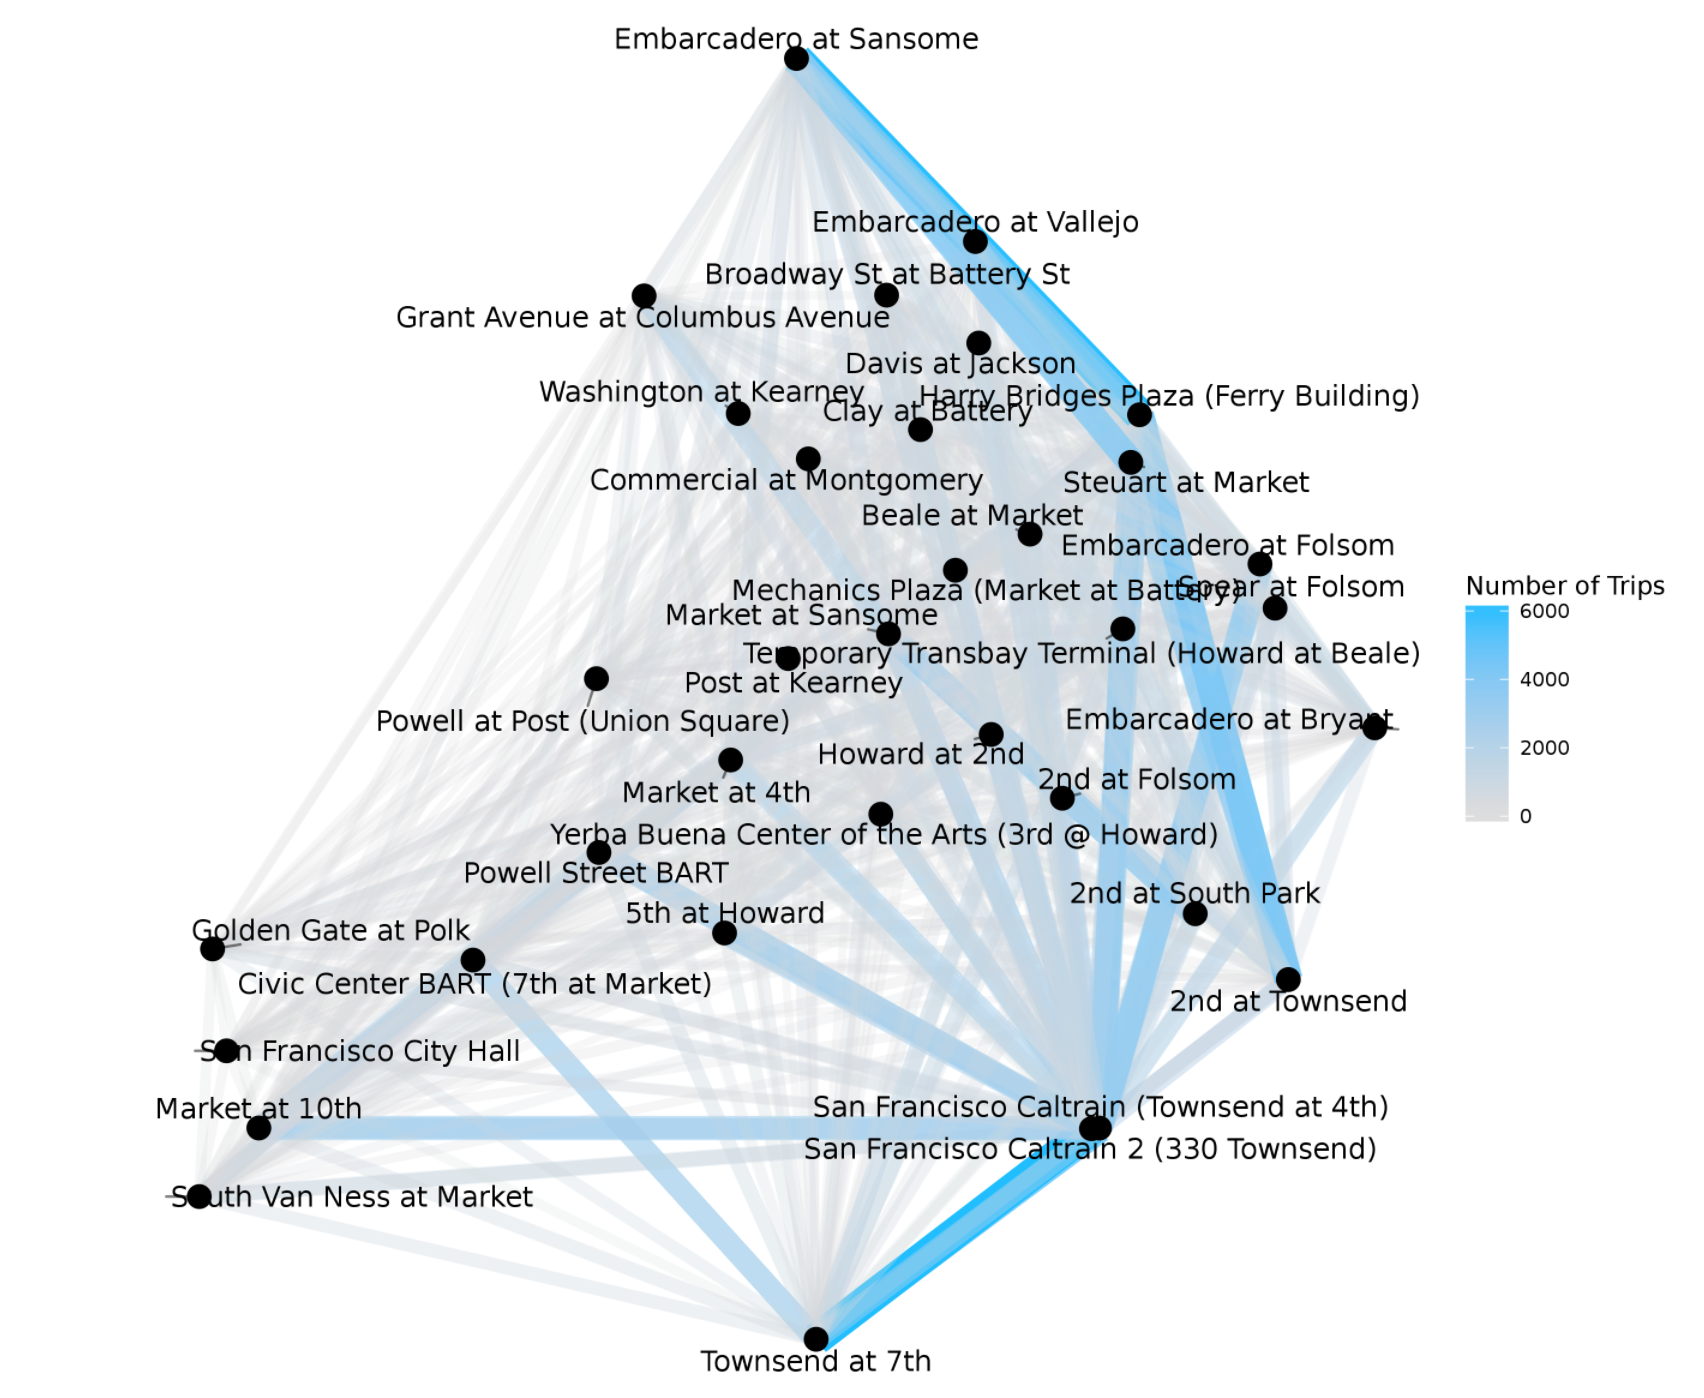

In [11]:
from IPython.display import Image
PATH = "/home/jovyan/work/"
Image(filename = PATH + "SF_Bike_Share_Trips.png", width=1000, height=1000)

## Part 2 - Wrangling (35 points)

Based on what you found above, wrangle the data into a format suitable for analysis. This may involve cleaning, filtering, merging, and modeling steps, any and all of which are valid for this project. Describe your process as you proceed, and document any scripts, databases, or other models you develop. Be specific about any key decisions to modify or remove data, how you overcame any challenges, and all assumptions you make about the meaning of variables and their values.

Verify that your wrangling steps have succeeded (for example, if you loaded the data into a dimensional model, ensure that the fact table contains the right number of records).

After initial investigation, it seems that our data is in good shape to be uploaded into a database. The following steps loads SQL and calls PostgreSQL.  Next, create the database.  In order to ensure code is reproducible, drop existing database called “finalproject” before creating a new one.  Create a new “finalproject” database and connect to it using the dbuser username.

*Note*: To use PostgreSQL on datanotebook.org, please uncomment the lines with username of `dbuser,` and also uncomment and run the commented out command below.

In [12]:
%load_ext sql

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [13]:
!echo 'redspot' | sudo -S service postgresql restart

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


In [14]:
!dropdb -U dbuser --if-exists finalproject

NOTICE:  database "finalproject" does not exist, skipping


In [15]:
!createdb -U dbuser finalproject

In [16]:
%sql postgresql://dbuser@localhost:5432/finalproject

'Connected: dbuser@finalproject'

### Create table and import

Looking at a sample of the data, we can determine the domain and range for each attribute. 

The following steps creates a shell table for each of the datasets provided.  The shell tables are called “station,” “trip,” and “weather.”  Each column is given a data format and length based on the csvstat output generated from the dataset based on the station.csv, trip.csv, and weather.csv datasets respectively.

In [17]:
%%sql
DROP TABLE IF EXISTS station;
CREATE TABLE station 
(
     ID INTEGER,
     NAME VARCHAR(45),
     LAT DOUBLE PRECISION,
     LONG DOUBLE PRECISION,
     DOCK_COUNT INTEGER,
     CITY VARCHAR(45),
     INSTALLATION_DATE TIMESTAMP
);
DROP TABLE IF EXISTS trip;
CREATE TABLE trip 
(
     ID INTEGER,
     DURATION INTEGER,
     START_DATE TIMESTAMP,
     START_STATION_NAME VARCHAR(45),
     START_STATION_ID INTEGER,
     END_DATE TIMESTAMP,
     END_STATION_NAME VARCHAR(45),
     END_STATION_ID INTEGER,
     BIKE_ID INTEGER,
     SUBSCRIPTION_TYPE CHAR(10),
     ZIP_CODE CHAR(15)
);
DROP TABLE IF EXISTS weather;
CREATE TABLE weather 
(
     DATE TIMESTAMP,
     MAX_TEMPERATURE_F DOUBLE PRECISION,
     MEAN_TEMPERATURE_F DOUBLE PRECISION,
     MIN_TEMPERATURE_F DOUBLE PRECISION,
     MAX_DEW_POINT_F DOUBLE PRECISION,
     MEAN_DEW_POINT_F DOUBLE PRECISION,
     MIN_DEW_POINT_F DOUBLE PRECISION,
     MAX_HUMIDITY DOUBLE PRECISION,
     MEAN_HUMIDITY DOUBLE PRECISION,
     MIN_HUMIDITY DOUBLE PRECISION,
     MAX_SEA_LEVEL_PRESSURE_INCHES DOUBLE PRECISION,
     MEAN_SEA_LEVEL_PRESSURE_INCHES DOUBLE PRECISION,
     MIN_SEA_LEVEL_PRESSURE_INCHES DOUBLE PRECISION,
     MAX_VISIBILITY_MILES DOUBLE PRECISION,
     MEAN_VISIBILITY_MILES DOUBLE PRECISION,
     MIN_VISIBILITY_MILES DOUBLE PRECISION,
     MAX_WIND_SPEED_MPH DOUBLE PRECISION,
     MEAN_WIND_SPEED_MPH DOUBLE PRECISION,
     MAX_GUST_SPEED_MPH DOUBLE PRECISION,
     PRECIPITATION_INCHES VARCHAR(4),
     CLOUD_COVER DOUBLE PRECISION,
     EVENTS VARCHAR(20),
     WIND_DIR_DEGREES DOUBLE PRECISION,
     ZIP_CODE INTEGER
);

Done.
Done.
Done.
Done.
Done.
Done.


[]

Now we'll load the data in more simply.  Note that this **requires** the use of an absolute path, so adjust it to your location:

In [18]:
!pwd

/home/jovyan/work


In [19]:
%%sql
COPY station FROM '/home/jovyan/work/station.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

COPY trip FROM '/home/jovyan/work/trip.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

COPY weather FROM '/home/jovyan/work/weather.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

70 rows affected.
250000 rows affected.
3665 rows affected.


[]

In [20]:
%%sql
SELECT count(*), 'station' as table_name FROM station
UNION 
SELECT count(*), 'trip' FROM trip
UNION
SELECT count(*), 'weather' FROM weather;

3 rows affected.


[(70, 'station'), (250000, 'trip'), (3665, 'weather')]

The following statement uses the INFORMATION_SCHEMA metadata database to extract a schema from a pgsql instance. This provides a quick overview of the column name, data type, and max character length. This allows us to understand the table structure, which will help us with analysis going forward.

In [21]:
%%sql
SELECT column_name, data_type, character_maximum_length
FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'station';

7 rows affected.


[('id', 'integer', None),
 ('name', 'character varying', 45),
 ('lat', 'double precision', None),
 ('long', 'double precision', None),
 ('dock_count', 'integer', None),
 ('city', 'character varying', 45),
 ('installation_date', 'timestamp without time zone', None)]

In [22]:
%%sql
SELECT column_name, data_type, character_maximum_length
FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'trip';

11 rows affected.


[('id', 'integer', None),
 ('duration', 'integer', None),
 ('start_date', 'timestamp without time zone', None),
 ('start_station_name', 'character varying', 45),
 ('start_station_id', 'integer', None),
 ('end_date', 'timestamp without time zone', None),
 ('end_station_name', 'character varying', 45),
 ('end_station_id', 'integer', None),
 ('bike_id', 'integer', None),
 ('subscription_type', 'character', 10),
 ('zip_code', 'character', 15)]

In [23]:
%%sql
SELECT column_name, data_type, character_maximum_length
FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'weather';

24 rows affected.


[('date', 'timestamp without time zone', None),
 ('max_temperature_f', 'double precision', None),
 ('mean_temperature_f', 'double precision', None),
 ('min_temperature_f', 'double precision', None),
 ('max_dew_point_f', 'double precision', None),
 ('mean_dew_point_f', 'double precision', None),
 ('min_dew_point_f', 'double precision', None),
 ('max_humidity', 'double precision', None),
 ('mean_humidity', 'double precision', None),
 ('min_humidity', 'double precision', None),
 ('max_sea_level_pressure_inches', 'double precision', None),
 ('mean_sea_level_pressure_inches', 'double precision', None),
 ('min_sea_level_pressure_inches', 'double precision', None),
 ('max_visibility_miles', 'double precision', None),
 ('mean_visibility_miles', 'double precision', None),
 ('min_visibility_miles', 'double precision', None),
 ('max_wind_speed_mph', 'double precision', None),
 ('mean_wind_speed_mph', 'double precision', None),
 ('max_gust_speed_mph', 'double precision', None),
 ('precipitation_inches', 'character varying', 4),
 ('cloud_cover', 'double precision', None),
 ('events', 'character varying', 20),
 ('wind_dir_degrees', 'double precision', None),
 ('zip_code', 'integer', None)]

The following code imputes values for null cells.  It is important to avoid null values and handle them accordingly when creating a usable data warehouse.  Please note that integer nulls are imputed as -999 and categorical nulls are imputed as "Null." From the csvstat output, only values in the following fields in the "weather" table contain null values.

In [24]:
%%sql
UPDATE weather SET max_temperature_f = -999 where max_temperature_f is null;
UPDATE weather SET mean_temperature_f = -999 where mean_temperature_f is null;
UPDATE weather SET min_temperature_f = -999 where min_temperature_f is null;
UPDATE weather SET max_dew_point_f = -999 where max_dew_point_f is null;
UPDATE weather SET mean_dew_point_f = -999 where mean_dew_point_f is null;
UPDATE weather SET min_dew_point_f = -999 where min_dew_point_f is null;
UPDATE weather SET max_humidity = -999 where max_humidity is null;
UPDATE weather SET mean_humidity = -999 where mean_humidity is null;
UPDATE weather SET min_humidity = -999 where min_humidity is null;
UPDATE weather SET max_sea_level_pressure_inches = -999 where max_sea_level_pressure_inches is null;
UPDATE weather SET mean_sea_level_pressure_inches = -999 where mean_sea_level_pressure_inches is null;
UPDATE weather SET min_sea_level_pressure_inches = -999 where min_sea_level_pressure_inches is null;
UPDATE weather SET max_visibility_miles = -999 where max_visibility_miles is null;
UPDATE weather SET mean_visibility_miles = -999 where mean_visibility_miles is null;
UPDATE weather SET min_visibility_miles = -999 where min_visibility_miles is null;
UPDATE weather SET max_wind_speed_mph = -999 where max_wind_speed_mph is null;
UPDATE weather SET mean_wind_speed_mph = -999 where mean_wind_speed_mph is null;
UPDATE weather SET max_gust_speed_mph = -999 where max_gust_speed_mph is null;
UPDATE weather SET precipitation_inches = -999 where precipitation_inches is null;
UPDATE weather SET cloud_cover = -999 where cloud_cover is null;
UPDATE weather SET wind_dir_degrees = -999 where wind_dir_degrees is null;
UPDATE weather SET events = 'N/A' where events is null;


4 rows affected.
4 rows affected.
4 rows affected.
54 rows affected.
54 rows affected.
54 rows affected.
54 rows affected.
54 rows affected.
54 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
13 rows affected.
13 rows affected.
13 rows affected.
1 rows affected.
1 rows affected.
899 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
3143 rows affected.


[]

View 5 rows of each table to ensure the data looks accurate.

In [25]:
%%sql 
SELECT *
FROM station
LIMIT 5
;

5 rows affected.


[(2, 'San Jose Diridon Caltrain Station', 37.329732, -121.901782, 27, 'San Jose', datetime.datetime(2013, 8, 6, 0, 0)),
 (3, 'San Jose Civic Center', 37.330698, -121.888979, 15, 'San Jose', datetime.datetime(2013, 8, 5, 0, 0)),
 (4, 'Santa Clara at Almaden', 37.333988, -121.894902, 11, 'San Jose', datetime.datetime(2013, 8, 6, 0, 0)),
 (5, 'Adobe on Almaden', 37.331415, -121.8932, 19, 'San Jose', datetime.datetime(2013, 8, 5, 0, 0)),
 (6, 'San Pedro Square', 37.336721, -121.894074, 15, 'San Jose', datetime.datetime(2013, 8, 7, 0, 0))]

In [26]:
%%sql 
SELECT *
FROM trip
LIMIT 5
;

5 rows affected.


[(4965, 129, datetime.datetime(2013, 8, 29, 19, 32), 'Mountain View Caltrain Station', 28, datetime.datetime(2013, 8, 29, 19, 35), 'Mountain View Caltrain Station', 28, 140, 'Subscriber', '94041          '),
 (4917, 169, datetime.datetime(2013, 8, 29, 18, 45), 'Redwood City Medical Center', 26, datetime.datetime(2013, 8, 29, 18, 48), 'Broadway at Main', 25, 229, 'Subscriber', '94041          '),
 (4721, 184, datetime.datetime(2013, 8, 29, 16, 27), 'Market at 10th', 67, datetime.datetime(2013, 8, 29, 16, 30), 'South Van Ness at Market', 66, 416, 'Subscriber', '94107          '),
 (4812, 186, datetime.datetime(2013, 8, 29, 17, 30), '2nd at Folsom', 62, datetime.datetime(2013, 8, 29, 17, 33), '2nd at Folsom', 62, 409, 'Subscriber', '94107          '),
 (4705, 193, datetime.datetime(2013, 8, 29, 16, 15), 'Golden Gate at Polk', 59, datetime.datetime(2013, 8, 29, 16, 18), 'San Francisco City Hall', 58, 519, 'Subscriber', '94107          ')]

In [27]:
%%sql 
SELECT *
FROM weather
LIMIT 5
;

5 rows affected.


[(datetime.datetime(2013, 9, 12, 0, 0), 71.0, 65.0, 59.0, 58.0, 57.0, 55.0, 84.0, 73.0, 61.0, 29.99, 29.95, 29.91, 10.0, 10.0, 9.0, 25.0, 11.0, 30.0, '0', 7.0, 'Fog', 268.0, 94107),
 (datetime.datetime(2013, 9, 21, 0, 0), 68.0, 63.0, 58.0, 59.0, 56.0, 53.0, 90.0, 75.0, 59.0, 29.91, 29.85, 29.82, 10.0, 9.0, 2.0, 24.0, 12.0, 28.0, '0.23', 6.0, 'Rain', 218.0, 94107),
 (datetime.datetime(2013, 9, 30, 0, 0), 73.0, 66.0, 59.0, 60.0, 57.0, 43.0, 87.0, 69.0, 51.0, 30.07, 30.03, 29.98, 10.0, 10.0, 10.0, 22.0, 10.0, 26.0, 'T', 4.0, 'Fog', 264.0, 94107),
 (datetime.datetime(2013, 10, 12, 0, 0), 64.0, 56.0, 47.0, 50.0, 46.0, 42.0, 89.0, 71.0, 53.0, 30.02, 29.98, 29.91, 10.0, 8.0, 0.0, 32.0, 13.0, 40.0, '0', 3.0, 'Fog', 252.0, 94107),
 (datetime.datetime(2013, 10, 20, 0, 0), 64.0, 57.0, 49.0, 52.0, 47.0, 45.0, 93.0, 77.0, 60.0, 30.03, 29.99, 29.92, 10.0, 8.0, 0.0, 22.0, 11.0, 26.0, '0', 2.0, 'Fog', 290.0, 94107)]

The following queries check to see if there are any duplicates for the columns that we were intending to use as unique identifiers in our star schema.

In [28]:
%%sql
SELECT count(*), id
FROM station
GROUP BY id
HAVING count(*)>1
;

0 rows affected.


[]

In [29]:
%%sql
SELECT count(*), id
FROM trip
GROUP BY id
HAVING count(*)>1
;

0 rows affected.


[]

Since we have identified issues with the zip code column in the trip data, create a new clean zipcode column.  Convert character zip code to 5 digit zip code which is an integer.  This will allow for a clean join onto the weather data.

In [30]:
%%sql
ALTER TABLE trip 
ADD COLUMN zip_code_clean INTEGER;


Done.


[]

In [31]:
%%sql
UPDATE trip
SET zip_code_clean = CAST(substring(trim(zip_code),1,5) as INTEGER)

250000 rows affected.


[]

In [32]:
%%sql
SELECT count(*), date, zip_code
FROM weather
GROUP BY date, zip_code
HAVING count(*)>1
;

0 rows affected.


[]

The following query checks unique values for the event column of the weather data. If there are any inconsistencies, then the query updates the table accordingly. As seen in the output of the code below, there are values for 'rain' and 'Rain'. As a result, we updated 'rain' to 'Rain'.

In [33]:
%%sql
SELECT events, count(*)
FROM weather
GROUP BY events
ORDER BY events asc
;

6 rows affected.


[('Fog', 112),
 ('Fog-Rain', 17),
 ('N/A', 3143),
 ('Rain', 388),
 ('Rain-Thunderstorm', 3),
 ('rain', 2)]

In [34]:
%%sql
UPDATE weather 
SET events = 'Rain' 
WHERE events = 'rain'
;

2 rows affected.


[]

In [35]:
%%sql
SELECT subscription_type, count(*)
FROM trip
GROUP BY subscription_type
ORDER BY subscription_type asc
;

2 rows affected.


[('Customer  ', 14803), ('Subscriber', 235197)]

## Define a star schema

Please note that to view the Star Schema image **requires** the use of an absolute path, so please adjust the PATH to your location:

In [36]:
!pwd

/home/jovyan/work


In [37]:
from IPython.display import Image
PATH = "/home/jovyan/work/"

The design of the star schema is shown below. The datasets were already somewhat into tables with unique keys, so this seemed like the natural choice.  The data could be separated into four different dimension tables.  The tables include station, weather, date-time, and duration. The station table contains information on the location of each station, how many docks are available, and when the station was created.  The weather dimension contains all of the information from the original weather table, and its weather dimension key is unique by date and zip code.  The date and time dimension has all columns related to trip date and time.  The purpose of parsing the columns is for ease of future analysis. The duration table contains all trip length in minutes, seconds, and hours.  

The fact table is unique by date, duration, start station, end station.  It is also unique by two additional fields: bike identifier and zip code.  After investigating using select distinct, it seems that the zip code does not correspond to the starting or ending station, but rather the zip code of the rider.  The bike identifier corresponds to the specific bike rode. Neither of these fields fit on a different dimension table, so we kept them on the fact table. To gather some numeric data, we converted the weather event column into a binary variable which counts the number of occurrences of rain storms, fog, rain, and fog-rain.  Similarly, we converted the subscription_type column to count the subscribers and count of casual riders.  If we want to use overall trip frequencies in the analysis, we can simply count the rows. The numeric values in the weather table are not included in the fact table because they are not additive values and are aggregated to mean, max, min, etc.    

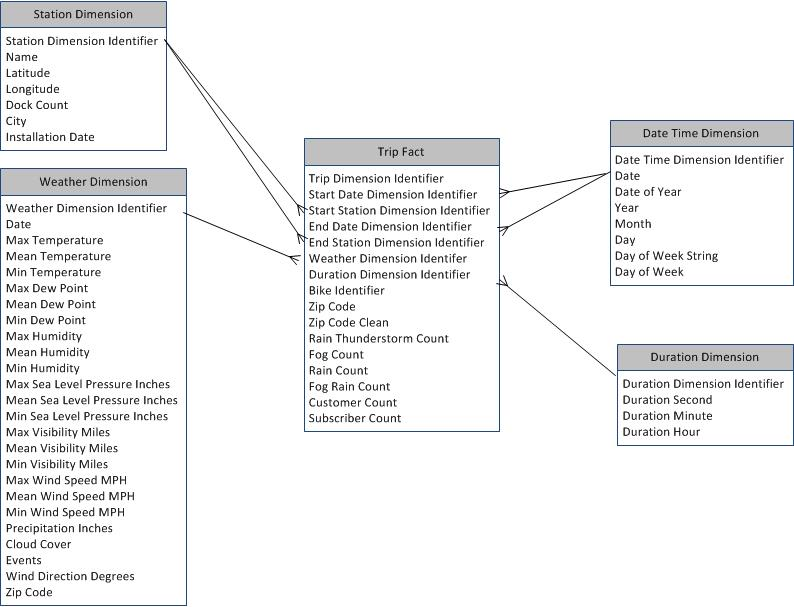

In [38]:
Image(filename = PATH + "SFBikeShareStarSchema.jpg", width=1000, height=1000)

#### The following statements create the Station Dimension table. 

First create a shell table with character and integer types.

In [39]:
%%sql
DROP TABLE IF EXISTS station_dim;
CREATE TABLE station_dim 
(  
     STATION_DIM_ID INTEGER DEFAULT NULL,
     NAME VARCHAR(45) DEFAULT NULL,
     LAT DOUBLE PRECISION DEFAULT NULL,
     LONG DOUBLE PRECISION DEFAULT NULL,
     DOCK_COUNT INTEGER DEFAULT NULL,
     CITY VARCHAR(45) DEFAULT NULL,
     INSTALLATION_DATE TIMESTAMP DEFAULT NULL 
);

Done.
Done.


[]

Next, insert station information from the source dataset.

In [40]:
%%sql
INSERT INTO station_dim
SELECT * from station
;

70 rows affected.


[]

See the final station dimension table below.

In [41]:
%%sql
select * from station_dim limit 5;

5 rows affected.


[(2, 'San Jose Diridon Caltrain Station', 37.329732, -121.901782, 27, 'San Jose', datetime.datetime(2013, 8, 6, 0, 0)),
 (3, 'San Jose Civic Center', 37.330698, -121.888979, 15, 'San Jose', datetime.datetime(2013, 8, 5, 0, 0)),
 (4, 'Santa Clara at Almaden', 37.333988, -121.894902, 11, 'San Jose', datetime.datetime(2013, 8, 6, 0, 0)),
 (5, 'Adobe on Almaden', 37.331415, -121.8932, 19, 'San Jose', datetime.datetime(2013, 8, 5, 0, 0)),
 (6, 'San Pedro Square', 37.336721, -121.894074, 15, 'San Jose', datetime.datetime(2013, 8, 7, 0, 0))]

#### The following statements create the Weather Dimension table.

In [42]:
%%sql
DROP TABLE IF EXISTS weather_dim;
CREATE TABLE weather_dim 
(    
     WEATHER_DIM_ID SERIAL PRIMARY KEY,
     DATE TIMESTAMP DEFAULT NULL,
     MAX_TEMPERATURE_F DOUBLE PRECISION DEFAULT NULL,
     MEAN_TEMPERATURE_F DOUBLE PRECISION DEFAULT NULL,
     MIN_TEMPERATURE_F DOUBLE PRECISION DEFAULT NULL,
     MAX_DEW_POINT_F DOUBLE PRECISION DEFAULT NULL,
     MEAN_DEW_POINT_F DOUBLE PRECISION DEFAULT NULL,
     MIN_DEW_POINT_F DOUBLE PRECISION DEFAULT NULL,
     MAX_HUMIDITY DOUBLE PRECISION DEFAULT NULL,
     MEAN_HUMIDITY DOUBLE PRECISION DEFAULT NULL,
     MIN_HUMIDITY DOUBLE PRECISION DEFAULT NULL,
     MAX_SEA_LEVEL_PRESSURE_INCHES DOUBLE PRECISION DEFAULT NULL,
     MEAN_SEA_LEVEL_PRESSURE_INCHES DOUBLE PRECISION DEFAULT NULL,
     MIN_SEA_LEVEL_PRESSURE_INCHES DOUBLE PRECISION DEFAULT NULL,
     MAX_VISIBILITY_MILES DOUBLE PRECISION DEFAULT NULL,
     MEAN_VISIBILITY_MILES DOUBLE PRECISION DEFAULT NULL,
     MIN_VISIBILITY_MILES DOUBLE PRECISION DEFAULT NULL,
     MAX_WIND_SPEED_MPH DOUBLE PRECISION DEFAULT NULL,
     MEAN_WIND_SPEED_MPH DOUBLE PRECISION DEFAULT NULL,
     MAX_GUST_SPEED_MPH DOUBLE PRECISION DEFAULT NULL,
     PRECIPITATION_INCHES VARCHAR(4) DEFAULT NULL,
     CLOUD_COVER DOUBLE PRECISION DEFAULT NULL,
     EVENTS VARCHAR(20) DEFAULT NULL,
     WIND_DIR_DEGREES DOUBLE PRECISION DEFAULT NULL,
     ZIP_CODE INTEGER DEFAULT NULL
);

Done.
Done.


[]

In [43]:
%%sql
INSERT INTO weather_dim 
     (
     date,
     max_temperature_f,
     mean_temperature_f,
     min_temperature_f,
     max_dew_point_f,
     mean_dew_point_f,
     min_dew_point_f,
     max_humidity,
     mean_humidity,
     min_humidity,
     max_sea_level_pressure_inches,
     mean_sea_level_pressure_inches,
     min_sea_level_pressure_inches,
     max_visibility_miles,
     mean_visibility_miles,
     min_visibility_miles,
     max_wind_Speed_mph,
     mean_wind_speed_mph,
     max_gust_speed_mph,
     precipitation_inches,
     cloud_cover,
     events,
     wind_dir_degrees,
     zip_code
     )
SELECT 
     date,
     max_temperature_f,
     mean_temperature_f,
     min_temperature_f,
     max_dew_point_f,
     mean_dew_point_f,
     min_dew_point_f,
     max_humidity,
     mean_humidity,
     min_humidity,
     max_sea_level_pressure_inches,
     mean_sea_level_pressure_inches,
     min_sea_level_pressure_inches,
     max_visibility_miles,
     mean_visibility_miles,
     min_visibility_miles,
     max_wind_Speed_mph,
     mean_wind_speed_mph,
     max_gust_speed_mph,
     precipitation_inches,
     cloud_cover,
     events,
     wind_dir_degrees,
     zip_code
from weather
;

3665 rows affected.


[]

In the below output, 5 records from the newly created table are shown  as a check.

In [44]:
%%sql
select * from weather_dim limit 5;

5 rows affected.


[(1, datetime.datetime(2013, 9, 12, 0, 0), 71.0, 65.0, 59.0, 58.0, 57.0, 55.0, 84.0, 73.0, 61.0, 29.99, 29.95, 29.91, 10.0, 10.0, 9.0, 25.0, 11.0, 30.0, '0', 7.0, 'Fog', 268.0, 94107),
 (2, datetime.datetime(2013, 9, 21, 0, 0), 68.0, 63.0, 58.0, 59.0, 56.0, 53.0, 90.0, 75.0, 59.0, 29.91, 29.85, 29.82, 10.0, 9.0, 2.0, 24.0, 12.0, 28.0, '0.23', 6.0, 'Rain', 218.0, 94107),
 (3, datetime.datetime(2013, 9, 30, 0, 0), 73.0, 66.0, 59.0, 60.0, 57.0, 43.0, 87.0, 69.0, 51.0, 30.07, 30.03, 29.98, 10.0, 10.0, 10.0, 22.0, 10.0, 26.0, 'T', 4.0, 'Fog', 264.0, 94107),
 (4, datetime.datetime(2013, 10, 12, 0, 0), 64.0, 56.0, 47.0, 50.0, 46.0, 42.0, 89.0, 71.0, 53.0, 30.02, 29.98, 29.91, 10.0, 8.0, 0.0, 32.0, 13.0, 40.0, '0', 3.0, 'Fog', 252.0, 94107),
 (5, datetime.datetime(2013, 10, 20, 0, 0), 64.0, 57.0, 49.0, 52.0, 47.0, 45.0, 93.0, 77.0, 60.0, 30.03, 29.99, 29.92, 10.0, 8.0, 0.0, 22.0, 11.0, 26.0, '0', 2.0, 'Fog', 290.0, 94107)]

#### The following statements create the Datetime Dimension table. This table includes the defined fields breaking the date out into parts.

Creating additional columns such as year, month, and day will increase efficiency of analysis, and is best practice in creating a star schema. Now, an analyst working with the data will be able to query these calculated fields directly instead of having to type in "TO_CHAR(offense_date, 'YYYY')" every time he or she wants to search/filter by one of these date breakouts.

In [45]:
%%sql
DROP TABLE IF EXISTS datetime_dim;
CREATE TABLE datetime_dim (
  datetime_dim_id SERIAL PRIMARY KEY,
  date TIMESTAMP DEFAULT NULL,
  day_of_year CHAR(10) DEFAULT NULL,
  year CHAR(4) DEFAULT NULL,
  month CHAR(2) DEFAULT NULL,
  day CHAR(2) DEFAULT NULL,
  day_of_week_str VARCHAR(9) DEFAULT NULL, 
  day_of_week CHAR(1) DEFAULT NULL
)
;

Done.
Done.


[]

In [46]:
%%sql
INSERT INTO datetime_dim (date)
SELECT distinct start_date
FROM trip
UNION
SELECT distinct end_date
FROM trip
;

307866 rows affected.


[]

In [47]:
%%sql
UPDATE datetime_dim
SET day_of_year = TO_CHAR(date, 'YYYY-MM-DD'),
    year = TO_CHAR(date, 'YYYY'),
    month = TO_CHAR(date, 'MM'),
    day = TO_CHAR(date, 'DD'),
    day_of_week_str = TO_CHAR(date, 'Day'),
    day_of_week = TO_CHAR(date, 'D')
;

307866 rows affected.


[]

In [48]:
%%sql
select * from datetime_dim limit 5;

5 rows affected.


[(1, datetime.datetime(2015, 7, 30, 22, 11), '2015-07-30', '2015', '07', '30', 'Thursday ', '5'),
 (2, datetime.datetime(2014, 1, 22, 15, 32), '2014-01-22', '2014', '01', '22', 'Wednesday', '4'),
 (3, datetime.datetime(2013, 10, 8, 5, 38), '2013-10-08', '2013', '10', '08', 'Tuesday  ', '3'),
 (4, datetime.datetime(2013, 12, 26, 14, 27), '2013-12-26', '2013', '12', '26', 'Thursday ', '5'),
 (5, datetime.datetime(2015, 5, 24, 8, 24), '2015-05-24', '2015', '05', '24', 'Sunday   ', '1')]

#### The following statements create the Duration Dimension table.

In [49]:
%%sql
DROP TABLE IF EXISTS duration_dim;
CREATE TABLE duration_dim (
  duration_dim_id SERIAL PRIMARY KEY,
  duration_sec REAL DEFAULT NULL,
  duration_min REAL DEFAULT NULL,
  duration_hour REAL DEFAULT NULL
)
;

Done.
Done.


[]

In [50]:
%%sql
INSERT INTO duration_dim (duration_sec)
SELECT distinct duration
FROM trip
;

5802 rows affected.


[]

In [51]:
%%sql
UPDATE duration_dim
SET duration_min = duration_sec/60,
    duration_hour = duration_sec/(3600)
;

5802 rows affected.


[]

In [52]:
%%sql
select * from duration_dim limit 5;

5 rows affected.


[(1, 251.0, 4.18333, 0.0697222),
 (2, 2848.0, 47.4667, 0.791111),
 (3, 2026.0, 33.7667, 0.562778),
 (4, 2409.0, 40.15, 0.669167),
 (5, 264.0, 4.4, 0.0733333)]

# The following statements create the Trip Fact table. 

In [53]:
%%sql
DROP TABLE IF EXISTS trip_fact;
CREATE TABLE trip_fact (
  TRIP_DIM_ID INTEGER,
  START_DATE_DIM_ID INTEGER,
  START_STATION_DIM_ID INTEGER, 
  END_DATE_DIM_ID INTEGER,
  END_STATION_DIM_ID INTEGER,   
  WEATHER_DIM_ID INTEGER, 
  DURATION_DIM_ID INTEGER,
  BIKE_ID INTEGER,  
  ZIP_CODE CHAR(15),
  ZIP_CODE_CLEAN INTEGER,
  RAIN_THUNDERSTORM_CNT INTEGER, 
  FOG_CNT INTEGER, 
  RAIN_CNT INTEGER, 
  FOG_RAIN_CNT INTEGER, 
  CUSTOMER_CNT INTEGER,
  SUBSCRIBER_CNT INTEGER
);

Done.
Done.


[]

#### The following statement updates the fact table with all the trip ids.

In [54]:
%%sql
INSERT INTO trip_fact (trip_dim_id, bike_id, zip_code, zip_code_clean)
SELECT 
    id, 
    bike_id, 
    zip_code,
    zip_code_clean
from trip
;

250000 rows affected.


[]

#### The following statement updates the fact table with the associated start and end station dim id.

In [55]:
%%sql
UPDATE 
  trip_fact T1  
SET 
  start_station_dim_id = T2.station_dim_id 
FROM 
  station_dim T2 
  INNER JOIN trip T3 ON T2.station_dim_id = T3.start_station_id
WHERE 
  T1.trip_dim_id = T3.id
;

UPDATE 
  trip_fact T1  
SET 
  end_station_dim_id = T2.station_dim_id 
FROM 
  station_dim T2 
  INNER JOIN trip T3 ON T2.station_dim_id = T3.end_station_id
WHERE 
  T1.trip_dim_id = T3.id
;

250000 rows affected.
250000 rows affected.


[]

#### The following statement updates the fact table with the associated start and end date dim id.

In [56]:
%%sql
UPDATE 
  trip_fact T1  
SET 
  start_date_dim_id = T2.datetime_dim_id 
FROM 
  datetime_dim T2 
  INNER JOIN trip T3 ON T2.date = T3.start_date
WHERE 
  T1.trip_dim_id = T3.id
;

UPDATE 
  trip_fact T1  
SET 
  end_date_dim_id = T2.datetime_dim_id 
FROM 
  datetime_dim T2 
  INNER JOIN trip T3 ON T2.date = T3.end_date
WHERE 
  T1.trip_dim_id = T3.id
;

250000 rows affected.
250000 rows affected.


[]

#### The following statement updates the fact table with the associated weather dim id.

In [57]:
%%sql
UPDATE 
  trip_fact T1  
SET 
  weather_dim_id = T2.weather_dim_id 
FROM 
  weather_dim T2 
  INNER JOIN trip T3 ON TO_CHAR(T2.date, 'YYYY-MM-DD') = TO_CHAR(T3.start_date, 'YYYY-MM-DD')
                    AND T2.zip_code = T3.zip_code_clean
WHERE 
  T1.trip_dim_id = T3.id
;

95309 rows affected.


[]

#### The following statement updates the fact table with the associated duration dim id.

In [58]:
%%sql
UPDATE 
  trip_fact T1  
SET 
  duration_dim_id = T2.duration_dim_id 
FROM 
  duration_dim T2 
  INNER JOIN trip T3 ON T2.duration_sec = T3.duration
WHERE 
  T1.trip_dim_id = T3.id
;

250000 rows affected.


[]

#### The following statement updates the fact table with the associated rain_thunderstorm, fog, rain, and fog_rain count.

In [59]:
%%sql
UPDATE 
    trip_fact T1
SET (RAIN_THUNDERSTORM_CNT, FOG_CNT, RAIN_CNT, FOG_RAIN_CNT) = 
    ( 
    CASE WHEN trim(T2.events) = 'Rain-Thunderstorm' THEN 1 ELSE 0 END,
    CASE WHEN trim(T2.events) = 'Fog' THEN 1 ELSE 0 END,
    CASE WHEN trim(T2.events) = 'Rain' THEN 1 ELSE 0 END,
    CASE WHEN trim(T2.events) = 'Fog-Rain' THEN 1 ELSE 0 END
    )
FROM
    weather_dim T2
WHERE
    T1.weather_dim_id = T2.weather_dim_id
;

95309 rows affected.


[]

The following code checks counts for each of the columns from the fact table.  The most frequent event is rain, which seems reasonable.

In [60]:
%%sql
select 'RAIN_THUNDERSTORM_CNT' as name, count(*) from trip_fact 
where RAIN_THUNDERSTORM_CNT = 1
union
select 'FOG_CNT' as name, count(*) from trip_fact 
where FOG_CNT = 1
union
select 'RAIN_CNT' as name, count(*) from trip_fact 
where RAIN_CNT = 1
union
select 'FOG_RAIN_CNT' as name, count(*) from trip_fact 
where FOG_RAIN_CNT = 1

4 rows affected.


[('FOG_RAIN_CNT', 1189),
 ('RAIN_THUNDERSTORM_CNT', 212),
 ('FOG_CNT', 6582),
 ('RAIN_CNT', 10554)]

#### The following statement updates the fact table with the associated customer and subscriber count.

In [61]:
%%sql
UPDATE 
    trip_fact T1
SET (CUSTOMER_CNT, SUBSCRIBER_CNT) = 
    ( 
    CASE WHEN subscription_type = 'Customer' THEN 1 ELSE 0 END,
    CASE WHEN subscription_type = 'Subscriber' THEN 1 ELSE 0 END
    )
FROM
    trip T2
WHERE
    T1.trip_dim_id = T2.id;

250000 rows affected.


[]

## Part 3 - Analysis (35 points)

Explore and analyze your data in its wrangled form. Follow through on the themes you identified in Part 1 with queries or scripts that answer the questions you had in mind. Be clear about the answers you discover, discussing them and whether the results match your expectations. Include charts or other visuals that support your analysis. You may use Tableau, ggplot, or other tools we have not covered in class for visualization, but be sure to export images and to include them properly in your writeup.

The output below shows the first five records in the fact table.  Columns 1-6 are all ID columns and the remaining columns contain the facts.

In [62]:
%%sql
select * from trip_fact limit 5;

5 rows affected.


[(4075, 189541, 66, 271028, 69, None, 1885, 316, '94122          ', 94122, None, None, None, None, 0, 1),
 (4080, 129058, 66, 270846, 69, None, 434, 315, '94117          ', 94117, None, None, None, None, 0, 1),
 (4081, 170391, 27, 297479, 27, None, 1761, 150, '97214          ', 97214, None, None, None, None, 0, 1),
 (4086, 109829, 45, 39333, 45, None, 1837, 379, '94402          ', 94402, None, None, None, None, 0, 1),
 (4116, 289847, 35, 12699, 36, None, 336, 83, '95112          ', 95112, None, None, None, None, 0, 1)]

From the following query, it is shown that there is an imbalanced sample by year and that most of the records are from 2014.

In [63]:
%%sql
select count(*), year
from trip_fact a join datetime_dim b on a.start_date_dim_id = b.datetime_dim_id
group by year
order by year ASC;

3 rows affected.


[(35846, '2013'), (120422, '2014'), (93732, '2015')]

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<Container object of 3 artists>

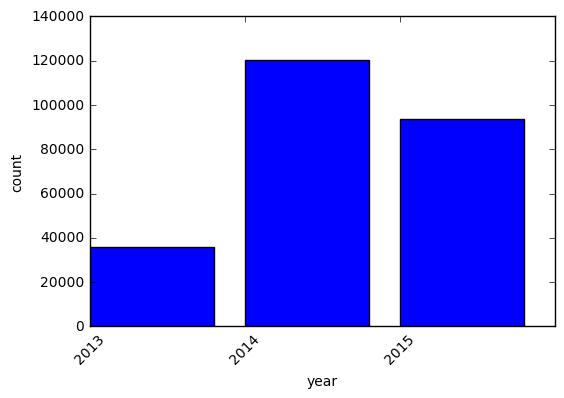

In [64]:
%matplotlib inline
result = _
result.bar()

Let's begin to explore how date and time variables affect ridership.

Exploring the month variable shows that ridership does tend to be higher in the summer months.  The trend seems to be true for both subscribers and non subscribers, yet non subscriber ridership peaking slightly later in the summer.

In [65]:
%%sql
SELECT 
    d.month, 
    SUM(t.CUSTOMER_CNT) AS CUSTOMER_TRIPS,
    SUM(t.SUBSCRIBER_CNT) AS SUBSCRIBER_TRIPS    
FROM trip_fact t 
INNER JOIN datetime_dim d on t.start_date_dim_id = d.datetime_dim_id
GROUP BY d.month
ORDER BY month ASC

12 rows affected.


[('01', 929, 19772),
 ('02', 830, 17311),
 ('03', 1098, 20775),
 ('04', 1090, 20779),
 ('05', 1176, 19900),
 ('06', 1128, 21100),
 ('07', 1278, 21191),
 ('08', 1428, 21650),
 ('09', 2402, 18024),
 ('10', 1563, 22187),
 ('11', 1164, 17988),
 ('12', 717, 14520)]

********LEGEND*********
Green: Subscriber Trips
Blue: Customer Trips


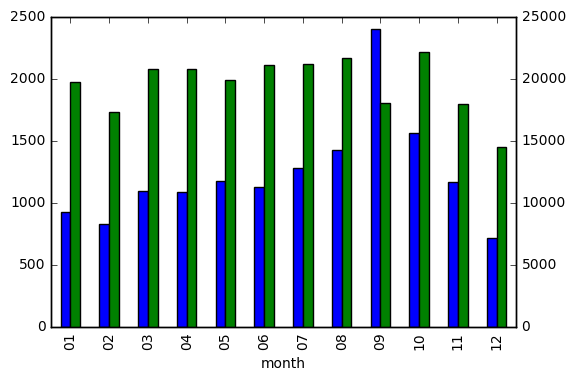

In [66]:
import matplotlib as plt
df = _.DataFrame()
df.plot(x='month', secondary_y='subscriber_trips', kind = 'bar',legend=None)
!echo '********LEGEND*********'
!echo 'Green: Subscriber Trips'
!echo 'Blue: Customer Trips'

From the following output, it seems that subscriber trip frequency is more steady, and customer trips have more of a seasonal pattern. However, recall that there was unevenly distributed data for each of the years, so this may be skewing results.  The following code shows distinct year-month combinations, along with trip count.  From this, it is shown that 2013 only contains the months of August through January, and 2015 only contains data from January through August.  In order to isolate seasonality, it might be best to only include the full 2014 year when analyzing it by month. 

In [67]:
%%sql
select 
d.year,
d.month,
Count(t.TRIP_DIM_ID)
FROM trip_fact t 
INNER JOIN datetime_dim d on t.start_date_dim_id = d.datetime_dim_id
GROUP BY d.month, d.year
ORDER BY 1,2


25 rows affected.


[('2013', '08', 599),
 ('2013', '09', 8434),
 ('2013', '10', 10475),
 ('2013', '11', 8967),
 ('2013', '12', 7371),
 ('2014', '01', 9316),
 ('2014', '02', 7078),
 ('2014', '03', 9081),
 ('2014', '04', 9414),
 ('2014', '05', 9910),
 ('2014', '06', 10424),
 ('2014', '07', 10947),
 ('2014', '08', 10934),
 ('2014', '09', 11992),
 ('2014', '10', 13275),
 ('2014', '11', 10185),
 ('2014', '12', 7866),
 ('2015', '01', 11385),
 ('2015', '02', 11063),
 ('2015', '03', 12792),
 ('2015', '04', 12455),
 ('2015', '05', 11166),
 ('2015', '06', 11804),
 ('2015', '07', 11522),
 ('2015', '08', 11545)]

In [68]:
%%sql
SELECT 
    d.month, 
    SUM(t.CUSTOMER_CNT) AS CUSTOMER_TRIPS,
    SUM(t.SUBSCRIBER_CNT) AS SUBSCRIBER_TRIPS    
FROM trip_fact t 
INNER JOIN datetime_dim d on t.start_date_dim_id = d.datetime_dim_id
WHERE d.year = '2014'
GROUP BY d.month
ORDER BY month ASC

12 rows affected.


[('01', 521, 8795),
 ('02', 417, 6661),
 ('03', 582, 8499),
 ('04', 566, 8848),
 ('05', 695, 9215),
 ('06', 667, 9757),
 ('07', 709, 10238),
 ('08', 665, 10269),
 ('09', 505, 11487),
 ('10', 593, 12682),
 ('11', 427, 9758),
 ('12', 287, 7579)]

********LEGEND*********
Green: Subscriber Trips
Blue: Customer Trips


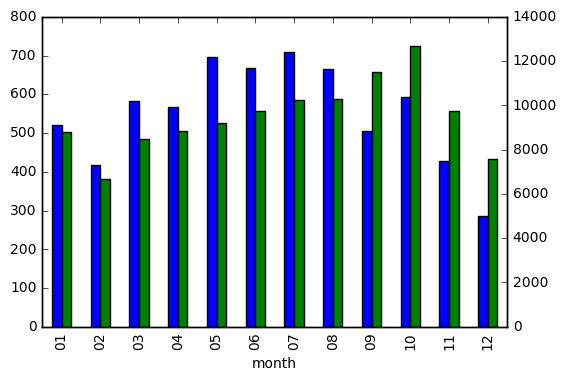

In [69]:
import matplotlib as plt
df = _.DataFrame()
df.plot(x='month', secondary_y='subscriber_trips', kind = 'bar',legend=None)
!echo '********LEGEND*********'
!echo 'Green: Subscriber Trips'
!echo 'Blue: Customer Trips'

From this output, it is shown that the seasonality of trips differs for customers versus subscribers.  Generally, over the summer months customer trips surpass subscriber trips. Customer trips start decreasing around September and continue to decrease through December.  Subsribers have a bit of an inverse behavior.  Subscriber use is relatively even through the summer months, increases in October and then declines at a steady rate in the winter.  The overall level of trips is higher in the winter for subscribers compared to customers.  

It is likely that subscribers depend on biking for their commute or for regular use.  That being said, it is less likely that adverse weather conditions would deter riding.  Customers, however, as seen in the seasonal look discussed above, seem to have more rides when the weather is nicer.  Let's look at the differences in the number of trips involving weather events such as rain, fog, etc.

In [70]:
%%sql
SELECT
    'CUSTOMER' as TYPE,
    (SUM(CAST(FOG_CNT AS FLOAT))/SUM(CAST(CUSTOMER_CNT AS FLOAT)))*100 AS FOG_PCT, 
    (SUM(CAST(RAIN_CNT AS FLOAT))/SUM(CAST(CUSTOMER_CNT AS FLOAT)))*100 AS RAIN_PCT, 
    (SUM(CAST(FOG_RAIN_CNT AS FLOAT))/SUM(CAST(CUSTOMER_CNT AS FLOAT)))*100 AS FOG_RAIN_PCT,
    (SUM(CAST(RAIN_THUNDERSTORM_CNT AS FLOAT))/SUM(CAST(CUSTOMER_CNT AS FLOAT)))*100 AS RAIN_THUNDER_PCT
FROM trip_fact t 
WHERE CUSTOMER_CNT = 1

UNION

SELECT
    'SUBSCRIBER' as TYPE,
    (SUM(CAST(FOG_CNT AS FLOAT))/SUM(CAST(SUBSCRIBER_CNT AS FLOAT)))*100 AS FOG_PCT, 
    (SUM(CAST(RAIN_CNT AS FLOAT))/SUM(CAST(SUBSCRIBER_CNT AS FLOAT)))*100 AS RAIN_PCT, 
    (SUM(CAST(FOG_RAIN_CNT AS FLOAT))/SUM(CAST(SUBSCRIBER_CNT AS FLOAT)))*100 AS FOG_RAIN_PCT,
    (SUM(CAST(RAIN_THUNDERSTORM_CNT AS FLOAT))/SUM(CAST(SUBSCRIBER_CNT AS FLOAT)))*100 AS RAIN_THUNDER_PCT
FROM trip_fact t 
WHERE SUBSCRIBER_CNT = 1


2 rows affected.


[('CUSTOMER', 1.23623589812876, 1.398365196244, 0.0135107748429372, 0.00675538742146862),
 ('SUBSCRIBER', 2.72069796808633, 4.39929080728071, 0.504683308035392, 0.0897120286398211)]

The output above shows what we had guessed earlier. Subscribers are much more likely to ride in adverse conditions compared to customers as a percentage of total trips each respective category.  The total percentage of trips in the rain and thunder for a customer was .00676% compared to .0897% for subscribers.  This pattern persists for each of the other categories.  This suggests that subscribers sometimes don't have a choice but to ride in inclement weather, if they have to commute, etc.

Investigating the day of week variable shows that ridership during weekdays far surpasses ridership on weekends.  However, when splitting the data between subscribers and non subscribers, it is clear that non-subscriber ridership increases on the weekends, while subscriber ridership drastically decreases on weekends.  

This indicates that may be a relationship between being a subscriber and using the bike as a means to commute to and from work.  Further more, it makes logical sense that casual ridership is highest Friday through Sunday, as these are the days of the week in which it is most common for tourists to visit the city.

One last interesting point is that among subscribers, ridership on Friday is lower than any other weekday.  It would seem to make more logical sense that Friday would have been the most popular weekday to subscriber ridership, as work schedules tend to be most flexible on Fridays and therefore most accommodating to a bike ride to / from work.

In [71]:
%%sql
SELECT d.day_of_week, COUNT(*) AS Count
FROM trip_fact t 
INNER JOIN datetime_dim d on t.start_date_dim_id = d.datetime_dim_id
GROUP BY d.day_of_week
ORDER BY day_of_week asc

7 rows affected.


[('1', 11968),
 ('2', 44114),
 ('3', 47039),
 ('4', 46180),
 ('5', 45560),
 ('6', 41033),
 ('7', 14106)]

<Container object of 7 artists>

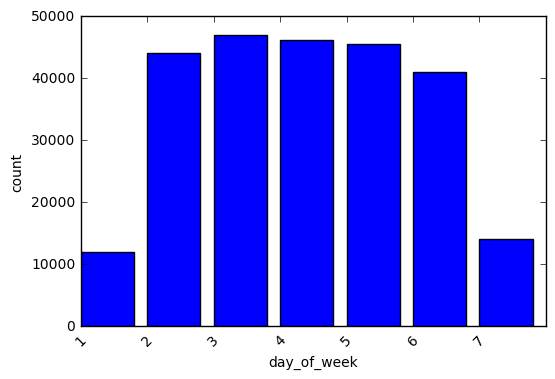

In [72]:
result = _
result.bar()

In [73]:
%%sql
SELECT 
    d.day_of_week, 
    SUM(t.CUSTOMER_CNT) AS CUSTOMER_TRIPS,
    SUM(t.SUBSCRIBER_CNT) AS SUBSCRIBER_TRIPS    
FROM trip_fact t 
INNER JOIN datetime_dim d on t.start_date_dim_id = d.datetime_dim_id
GROUP BY d.day_of_week
ORDER BY day_of_week

7 rows affected.


[('1', 2994, 8974),
 ('2', 1553, 42561),
 ('3', 1501, 45538),
 ('4', 1727, 44453),
 ('5', 1787, 43773),
 ('6', 2103, 38930),
 ('7', 3138, 10968)]

********LEGEND*********
Green: Subscriber Trips
Blue: Customer Trips


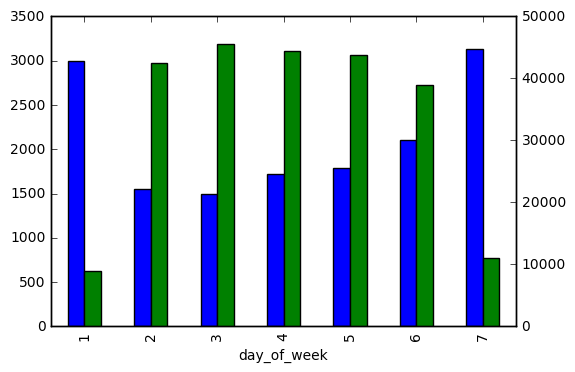

In [74]:
import matplotlib as plt
df = _.DataFrame()
df.plot(x='day_of_week', secondary_y='subscriber_trips', kind = 'bar',legend=None)
!echo '********LEGEND*********'
!echo 'Green: Subscriber Trips'
!echo 'Blue: Customer Trips'

Next, let's look at the average duration of trips by day of the week, and then separated by customer versus subscribers.  The following code filters to trips lasting less than an hour and shows the average duration in minutes by day of week.  The minute length seems fairly consistent for each day of the week.

In [75]:
%%sql
SELECT d.day_of_week, AVG(l.duration_min) AS Trip_Length_in_Minutes
FROM trip_fact t 
INNER JOIN datetime_dim d 
    on t.start_date_dim_id = d.datetime_dim_id
INNER JOIN duration_dim l 
    on t.start_date_dim_id = l.duration_dim_id
where l.duration_min <= 20
GROUP BY d.day_of_week
ORDER BY day_of_week

7 rows affected.


[('1', 9.472826079182),
 ('2', 10.9192829624165),
 ('3', 9.89047618625926),
 ('4', 10.7815118037938),
 ('5', 10.572425841661),
 ('6', 10.3504761465958),
 ('7', 10.3588889307446)]

Now, let's look at the average duration for casual riders versus subscribers. When limiting the trip time to 20 minutes, there is not really much of a material difference in trip times in casual versus subscribers.  For these short rides, subscribers are slightly lower in most days, but the difference is very slight.

In [76]:
%%sql
SELECT d.day_of_week, 
sum(cast((case when t.CUSTOMER_CNT = 1 then l.duration_min else 0 end) AS FLOAT))/sum(cast(t.CUSTOMER_CNT AS FLOAT)) AS Avg_Casual_Trip_Length_Min,
sum(cast((case when t.SUBSCRIBER_CNT = 1 then l.duration_min else 0 end) AS FLOAT))/sum(cast(t.SUBSCRIBER_CNT AS FLOAT)) AS Avg_Subscriber_Trip_Length_Min,
AVG(l.duration_min) as Total_Avg_Trip_Length_Min
FROM trip_fact t 
INNER JOIN datetime_dim d 
    on t.start_date_dim_id = d.datetime_dim_id
INNER JOIN duration_dim l 
    on t.start_date_dim_id = l.duration_dim_id
where l.duration_min <= 20
GROUP BY d.day_of_week
ORDER BY day_of_week

7 rows affected.


[('1', 14.0111112329695, 8.36891887961207, 9.472826079182),
 ('2', 14.1791667938232, 10.8416666807163, 10.9192829624165),
 ('3', 13.3520835936069, 9.69124698295868, 9.89047618625926),
 ('4', 10.9374999304612, 10.770565268589, 10.7815118037938),
 ('5', 10.6125000715256, 10.5706739627598, 10.572425841661),
 ('6', 8.21666649409703, 10.46278191778, 10.3504761465958),
 ('7', 9.09999997615814, 10.5162500500679, 10.3588889307446)]

In increasing the length of trip to 90 minutes, we can observe the differences in subscriber and casual rider trip length for longer trips. There more noticible of a difference between the duration of casual and subscriber trips when increasing maximimum length per ride.  It seems that weekday trips are shorter for Subscribers compared to Casual riders.  This could suggest that Subscribers are more efficient when riding than Casual commuters. When it comes to shorter trips, however, the durations are pretty much even, as seen in the preceeding query.

In [77]:
%%sql
SELECT d.day_of_week, 
sum(cast((case when t.CUSTOMER_CNT = 1 then l.duration_min else 0 end) AS FLOAT))/sum(cast(t.CUSTOMER_CNT AS FLOAT)) AS Avg_Casual_Trip_Length_Min,
sum(cast((case when t.SUBSCRIBER_CNT = 1 then l.duration_min else 0 end) AS FLOAT))/sum(cast(t.SUBSCRIBER_CNT AS FLOAT)) AS Avg_Subscriber_Trip_Length_Min,
AVG(l.duration_min) as Total_Avg_Trip_Length_Min
FROM trip_fact t 
INNER JOIN datetime_dim d 
    on t.start_date_dim_id = d.datetime_dim_id
INNER JOIN duration_dim l 
    on t.start_date_dim_id = l.duration_dim_id
where l.duration_min <= 90
GROUP BY d.day_of_week
ORDER BY day_of_week

7 rows affected.


[('1', 39.1269230659191, 33.1515721813688, 34.7587355227306),
 ('2', 35.4130952017648, 36.973197424454, 36.9354094813439),
 ('3', 31.8222225639555, 35.2568316969541, 35.1386233520325),
 ('4', 28.8526669740677, 35.6368613421482, 35.340866823471),
 ('5', 34.7424242279746, 35.404648885555, 35.3781116497321),
 ('6', 34.9630434202111, 35.9643888009165, 35.9145382733056),
 ('7', 42.7294870477456, 36.7531745887938, 37.7754385620356)]

Lastly, let's investigate whether there is a relationship between day of month and ridership.

For subscribers, it looks like ridership is fairly consistent throughout the month, with slightly lower ridership at the beginning and end of the month.  The 31st day of the month can be explained by the fact that not all months have 30 days.  However, it is interesting to see that the 1st-2nd and the 25th-30th days of the month appear to have lower ridership.  We would need to conduct inference to determine whether the differences are in fact statistically significant, or whether the differences are occuring by chance.

For non-subscribers, ridership by day of the month is a bit more random, with peaks and valleys occuring throughout the month.  Further analysis could be conducted to identify whether those days of the month were more likely to fall on Friday, Saturday, or Sunday within date range of the data set.

In [78]:
%%sql
SELECT d.day, COUNT(*) AS Count
FROM trip_fact t 
INNER JOIN datetime_dim d on t.start_date_dim_id = d.datetime_dim_id
GROUP BY d.day
ORDER BY day

31 rows affected.


[('01', 6754),
 ('02', 7595),
 ('03', 8274),
 ('04', 8247),
 ('05', 8376),
 ('06', 8259),
 ('07', 8064),
 ('08', 8075),
 ('09', 8449),
 ('10', 8838),
 ('11', 8399),
 ('12', 8673),
 ('13', 9123),
 ('14', 8500),
 ('15', 8192),
 ('16', 8408),
 ('17', 9049),
 ('18', 8904),
 ('19', 7988),
 ('20', 8467),
 ('21', 8223),
 ('22', 8074),
 ('23', 8345),
 ('24', 8702),
 ('25', 7618),
 ('26', 7495),
 ('27', 7995),
 ('28', 7457),
 ('29', 7446),
 ('30', 7727),
 ('31', 4284)]

<Container object of 31 artists>

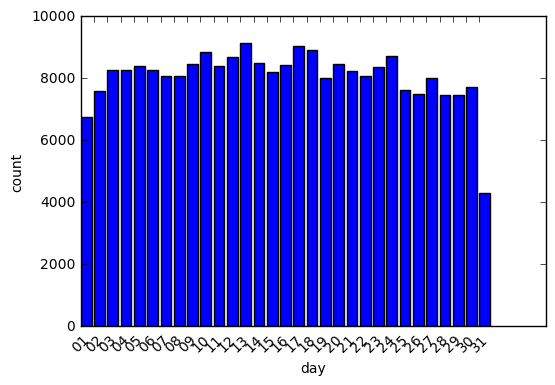

In [79]:
result = _
result.bar()

In [80]:
%%sql
SELECT 
    d.day, 
    SUM(t.CUSTOMER_CNT) AS CUSTOMER_TRIPS,
    SUM(t.SUBSCRIBER_CNT) AS SUBSCRIBER_TRIPS    
FROM trip_fact t 
INNER JOIN datetime_dim d on t.start_date_dim_id = d.datetime_dim_id
GROUP BY d.day
ORDER BY day

31 rows affected.


[('01', 598, 6156),
 ('02', 455, 7140),
 ('03', 449, 7825),
 ('04', 461, 7786),
 ('05', 457, 7919),
 ('06', 479, 7780),
 ('07', 491, 7573),
 ('08', 524, 7551),
 ('09', 395, 8054),
 ('10', 432, 8406),
 ('11', 460, 7939),
 ('12', 465, 8208),
 ('13', 516, 8607),
 ('14', 570, 7930),
 ('15', 649, 7543),
 ('16', 543, 7865),
 ('17', 437, 8612),
 ('18', 471, 8433),
 ('19', 535, 7453),
 ('20', 484, 7983),
 ('21', 379, 7844),
 ('22', 517, 7557),
 ('23', 469, 7876),
 ('24', 424, 8278),
 ('25', 514, 7104),
 ('26', 490, 7005),
 ('27', 455, 7540),
 ('28', 423, 7034),
 ('29', 472, 6974),
 ('30', 461, 7266),
 ('31', 328, 3956)]

********LEGEND*********
Green: Subscriber Trips
Blue: Customer Trips


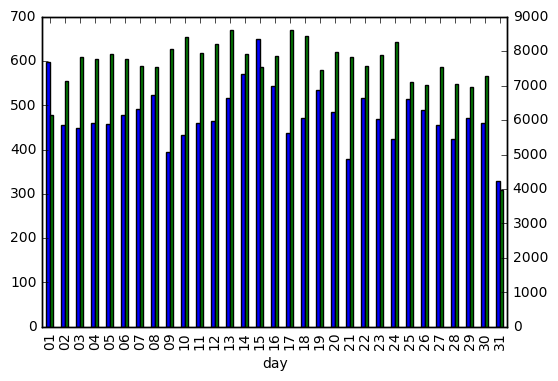

In [81]:
import matplotlib as plt
df = _.DataFrame()
df.plot(x='day', secondary_y='subscriber_trips', kind = 'bar',legend=None)
!echo '********LEGEND*********'
!echo 'Green: Subscriber Trips'
!echo 'Blue: Customer Trips'

### Conclusion
Customers and Subscribers show different patterns in use, most specifically by day of week
- Should SF Bikeshare designate bikes to just subscribers vs customers?

Future steps to improve analysis:
- More accurate zip code information for trip dataset
- Expand weather information for additional zip codes
- Expand characteristic data for subscriber
    - Low, Medium, High Usage Rate
- Observe rider activity in comparison to public transportation issues / traffic
    - Example – Safe Track’s effect on DC Capital Bikeshare


## Attestation: 
- Lee: analysis, editing
- Divya: creation of presentation
- Eugene: creation of star schema, main force behind data cleaning and wrangling
- Marissa: data sampling, analysis, write up, extra credit

## Bonus - Augment (10 points)

Sometimes the most value can be gained from one dataset when it is studied alongside data drawn from other sources. Identify at least one additional data source that can complement your analysis. Pull this additional data into your chosen environment and explore at least one more theme you are able to further analyze that depends upon a combination of data from both sources.

In order to gain some more insight into our analysis, we uploaded data from SFdata, which provides open source data related to San Francisco.  We chose a dataset which had a list of active businesses in the San Francisco area.  It can be accessed through the following link: https://data.sfgov.org/Economy-and-Community/Active-Business-Locations/kvj8-g7jh.

In [82]:
!wget https://github.com/mwiener09/istm-6212/raw/master/final/Active_Business_Locations.zip

--2016-12-06 04:01:26--  https://github.com/mwiener09/istm-6212/raw/master/final/Active_Business_Locations.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mwiener09/istm-6212/master/final/Active_Business_Locations.zip [following]
--2016-12-06 04:01:27--  https://raw.githubusercontent.com/mwiener09/istm-6212/master/final/Active_Business_Locations.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5912408 (5.6M) [application/octet-stream]
Saving to: ‘Active_Business_Locations.zip’

Active_Business_Loc 100%[=====================>]   5.64M  --.-KB/s   in 0.08s  

2016-12-06 04:01:27 (69.4 MB/s) - ‘Active_Business_L

In [83]:
!unzip Active_Business_Locations.zip

Archive:  Active_Business_Locations.zip
  inflating: Active_Business_Locations.csv  


We thought it could be interesting to use this data table to create a lookup table by Zip Code which would count the number of active businesses for each.  This could show some sort of relationship with number of active businesses and trips.

In [84]:
!csvcut -n Active_Business_Locations.csv

  1: Location Id
  2: Business Account Number
  3: Ownership Name
  4: DBA Name
  5: Street Address
  6: City
  7: State
  8: Source Zipcode
  9: Business Start Date
 10: Business End Date
 11: Location Start Date
 12: Location End Date
 13: Mail Address
 14: Business Location


In [85]:
!csvcut -c1,8 Active_Business_Locations.csv > business.csv

Create a new CSV which only contains Location ID and Zipcode so that we can upload that table into our SQL database and then summarize it and create a lookup table.  First create shell table using formatting and length from csvstat output below. Then, copy business.csv file into table on the finalproject schema.

In [86]:
!csvstat business.csv

  1. Location Id
	<class 'str'>
	Nulls: False
	Unique values: 108581
	Max length: 14
  2. Source Zipcode
	<class 'str'>
	Nulls: True
	Unique values: 147
	5 most frequent values:
		94110:	8754
		94103:	7648
		94109:	6468
		94107:	6285
		94102:	5536
	Max length: 5

Row count: 108581


In [87]:
%%sql
DROP TABLE IF EXISTS active_business;
CREATE TABLE active_business (
  LOCATION_ID CHAR(14),
  ZIPCODE CHAR(5)
);

Done.
Done.


[]

In [88]:
%%sql
COPY active_business FROM '/home/jovyan/work/business.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

108581 rows affected.


[]

This is the table which is currently loaded into the database.

In [89]:
%%sql
SELECT * FROM active_business limit 10;

10 rows affected.


[('0000071-02-001', '94123'),
 ('0000265-06-002', '94124'),
 ('0000265-06-003', '94105'),
 ('0000265-06-004', '94108'),
 ('0000265-06-005', '94107'),
 ('0000265-06-006', '94109'),
 ('0000265-06-007', '94102'),
 ('0000265-06-008', '94102'),
 ('0000265-07-001', '94109'),
 ('0000265-08-001', '94107')]

Next, create the lookup table by counting location ID for each zip code.  Filter to top 10 most frequent.

In [90]:
%%sql
create table business_activity_lookup as
SELECT
CAST(ZIPCODE AS INTEGER) AS ZIP_CODE,
COUNT(LOCATION_ID) AS ACTIVE_BUSINESS_COUNT
from active_business
GROUP BY 1
;

148 rows affected.


[]

In [91]:
%%sql
select * from business_activity_lookup 
order by 2 desc
limit 10;

10 rows affected.


[(94110, 8754),
 (94103, 7648),
 (94109, 6468),
 (94107, 6285),
 (94102, 5536),
 (94122, 5133),
 (94118, 5039),
 (94112, 4914),
 (94114, 4620),
 (94117, 4607)]

The code below takes the top 10 active business zip codes and finds the distribution of customer vs subscriber trips for each.  Generally, it seems that there is less of a distribution for subscribers for all of the top 10 zip codes.  This may suggest that the other locations may have many local businesses such as restaurants and shops, whereas the most popular zip code has active businesses where subscribers work or have to travel more often than people who only ride casually. This sort of data could be used to distinguish zip codes with higher percentages of businesses which would appeal to the customer versus zip codes which attract more subscribers (94107 and 94103) which attract more subscriber rides.


In [92]:
%%sql
SELECT
    A.ZIP_CODE_CLEAN,
    sum(CAST(A.CUSTOMER_CNT AS FLOAT))*100/(SELECT COUNT(TRIP_DIM_ID) FROM trip_fact WHERE CUSTOMER_CNT = 1) AS CUSTOMER_PCT,
    sum(CAST(A.SUBSCRIBER_CNT AS FLOAT))*100/(SELECT COUNT(TRIP_DIM_ID) FROM trip_fact WHERE SUBSCRIBER_CNT = 1) AS SUBSCRIBER_PCT,
    B.ACTIVE_BUSINESS_COUNT
FROM trip_fact AS A
    INNER JOIN (SELECT
                    CAST(ZIPCODE AS INTEGER) AS ZIP_CODE,
                    COUNT(LOCATION_ID) AS ACTIVE_BUSINESS_COUNT
                from active_business
                GROUP BY 1
                ORDER BY 2 DESC
                LIMIT 10) AS B
        on A.ZIP_CODE_CLEAN = B.ZIP_CODE
    GROUP BY 1,4
    ORDER BY B.ACTIVE_BUSINESS_COUNT DESC;

10 rows affected.


[(94110, 1.56049449435925, 0.908174849168994, 8754),
 (94103, 2.53327028305073, 3.26109601738117, 7648),
 (94109, 2.18874552455583, 1.65095643226742, 6468),
 (94107, 15.8954266027157, 32.4668256823004, 6285),
 (94102, 2.46571640883605, 2.38863590947163, 5536),
 (94122, 0.682294129568331, 0.586742177833901, 5133),
 (94118, 0.607984867932176, 0.391161451889267, 5039),
 (94112, 0.743092616361548, 0.43197829904293, 4914),
 (94114, 0.857934202526515, 0.828667032317589, 4620),
 (94117, 1.29027899750051, 1.20112076259476, 4607)]

##  END